In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


# Partie 1 : Architecture VGG16

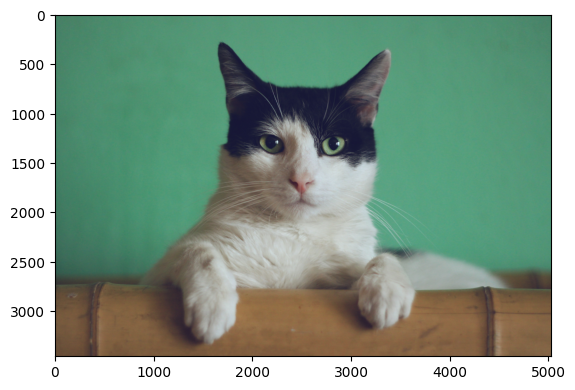

Predicted class : Egyptian cat | Score = 10.1156587600708 | Probability = 0.2117885798215866


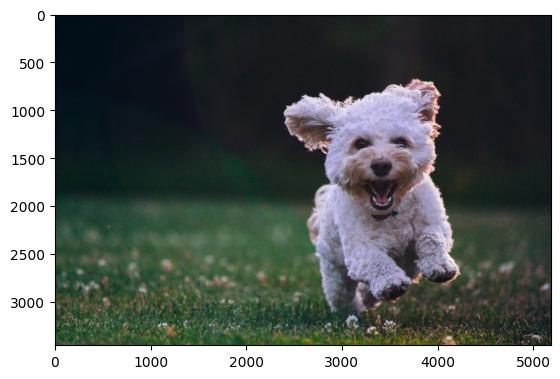

Predicted class : miniature schnauzer | Score = 13.478543281555176 | Probability = 0.4663673937320709


In [ ]:
list_img = ['cat.jpg', 'dog.jpg']
vgg16 = torchvision.models.vgg16(pretrained=True)
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes

for name in list_img:
  img = Image.open(name)
  plt.imshow(img)
  plt.show()
  img = img.resize((224, 224), Image.BILINEAR)
  img = np.array(img, dtype=np.float32) / 255

  # TODO preprocess image
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

  img = transform(img)

  img = np.expand_dims(img, 0)
  x = torch.Tensor(img)
  # TODO forward pass
  y = vgg16(x)
  y = y.detach().numpy() # transformation en array numpy

  #Softmax
  y_proba = np.exp(y[0])/sum(np.exp(y[0]))

  # TODO obtain predicted class and its score
  classe = np.argmax(y[0])
  score = y[0][classe]
  proba = y_proba[classe]

  print(f"Predicted class : {imagenet_classes[classe]} | Score = {score} | Probability = {proba}")

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Remove the fully connected layers to access the convolutional layers
vgg16_features = vgg16.features

# Set the model to evaluation mode
vgg16_features.eval()

# Load and preprocess an example image
image_path = 'dog.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
input_image = preprocess(image).unsqueeze(0)

# Forward pass to obtain activations
with torch.no_grad():
    activations = vgg16_features(input_image)

# Visualize the activations
activation_maps = activations.numpy()
num_activations = activation_maps.shape[1]

# Plot each activation map

for i in range(num_activations):
  plt.imshow(activation_maps[0, i, :, :], cmap='viridis')
  plt.axis('off')
  plt.title(f'Activation Map {i + 1}')

  plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2023-11-18 16:40:08--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2023-11-18 16:40:09--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M  25.9MB/s    in 3.2s    

2023-11-18 16:40:15 (25.9 MB/s) - ‘15ScenesData.zip’ saved [86520868/865208

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0035.jpg  image_0068.jpg  image_0103.jpg  image_0141.jpg  image_0182.jpg
image_0004.jpg  image_0037.jpg  image_0069.jpg  image_0104.jpg  image_0142.jpg  image_0189.jpg
image_0006.jpg  image_0039.jpg  image_0071.jpg  image_0112.jpg  image_0144.jpg  image_0190.jpg
image_0007.jpg  image_0040.jpg  image_0073.jpg  image_0113.jpg  image_0148.jpg  image_0191.jpg
image_0008.jpg  image_0042.jpg  image_0074.jpg  image_0114.jpg  image_0150.jpg  image_0192.jpg
image_0011.jpg  image_0043.jpg  image_0077.jpg  image_0115.jpg  image_0152.jpg  image_0195.jpg
image_0013.jpg  image_0047.jpg  image_0080.jpg  image_0117.jpg  image_0153.jpg  image_0196.jpg
image_0014.jpg  image_0049.jpg  image_0081.jpg  image_0118.jpg  image_0156.jpg  image_0200.jpg
image_0016.jpg  image_0050.jpg  image_0082.jpg  image_0119.jpg  image_0157.jpg  image_0202.jpg
image_0017.jpg  image_0052.jpg  image_0084.jpg  image_0120.jpg  image_0158.jpg  image_0203.jpg
image_0018.jpg  image_0053.jpg  image_0086.jpg  im

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self, i=-2): # By default -2 for extraction at relu7
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:i])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Resize((224,224), interpolation=Image.NEAREST),
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Resize((224,224), interpolation=Image.NEAREST),
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
!pip install torchmetrics
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Accuracy

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,15)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu = nn.ReLU

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    with torch.no_grad():
      # init features matrices
      X = torch.tensor([]).cuda()
      y = torch.tensor([])
      ####################
      ##      FIN        #
      ####################

      for i, (input, target) in enumerate(data):
          if i % PRINT_INTERVAL == 0:
              print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
          if CUDA:
              input = input.cuda()
          #####################
          ## Votre code ici  ##
          #####################
          # Feature extraction à faire
          X = torch.cat((X, model(input)))
          y = torch.cat((y, target))
          ####################
          ##      FIN        #
          ####################
    return X, y


def main(path="15SceneData", batch_size=8, C=1, layer=-2, fcl=False):
    print(f"Batch : {batch_size} | C : {C} | Layer : {layer}")
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7(i=layer)
    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    if (not fcl):
      print('Apprentissage des SVM')
      svm = LinearSVC(C=C)
      svm.fit(X_train.cpu(), y_train.cpu())
      accuracy = accuracy_score(y_test.cpu(), svm.predict(X_test.cpu()))
      ####################
      ##      FIN        #
      ####################
      print('Accuracy = %f' % accuracy)
      return accuracy

    else : # replacement of fully connected layer
      device = "cuda" if torch.cuda.is_available() else "cpu"

      train_acc, test_acc, train_l, test_l = [], [], [], []

      LR = 0.01
      EPOCH = 10

      train_loader = torch.utils.data.DataLoader(
          torch.utils.data.TensorDataset(F.normalize(X_train, p=2, dim=1), y_train.type(torch.LongTensor)),
          batch_size=batch_size,
          shuffle=True,
          num_workers=2,
      )

      test_loader = torch.utils.data.DataLoader(
          torch.utils.data.TensorDataset(F.normalize(X_test, p=2, dim=1), y_test.type(torch.LongTensor)),
          batch_size=batch_size,
          shuffle=False,
          num_workers=2,
      )

      model = Model()
      model = model.to(device)
      loss_fn = nn.CrossEntropyLoss()

      acc_fn = Accuracy(task="multiclass", num_classes= 18).to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=LR)

      print("test")

      for epoch in range(EPOCH):
        train_loss = 0
        model.train()
        print("test")
        for x,y in train_loader:
          print("test")
          x, y = x.to(device), y.to(device)
          print("test")
          y_pred = model(x)
          loss = loss_fn(y, y_pred)
          train_loss += loss.item()
          acc_fn(y_pred.argmax(1), y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        train_loss /= len(train_loader)
        train_accuracy = acc_fn.compute().item()
        model.eval()
        with torch.no_grad():
          for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y, y_pred)
            test_loss += loss.item()
            acc_fn(y_pred.argmax(1), y)

          test_loss /= len(test_loader)
          test_accuracy = acc_fn.compute().item()

        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        train_l.append(train_loss)
        test_l.append(test_loss)
        plt.plot(train_acc)



In [ ]:
main("15SceneData", fcl=False)

Batch : 8 | C : 1 | Layer : -2
Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.885092


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8850921273031825

#Going further

Tuning the parameter C to improve performance -- Not much effect

In [ ]:
C = [0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 3]
accuracies=[]
for c in C:
  accuracies.append(main("15SceneData", C=c))

for i in range(len(accuracies)):
  print("C value:", c[i], "and accuracy obtained with this value for C:", accuracies[i])

Batch : 8 | C : 0.01 | Layer : -2
Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.891122
Batch : 8 | C : 0.1 | Layer : -2
Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


KeyboardInterrupt: ignored

Text(0, 0.5, 'Accuracy')

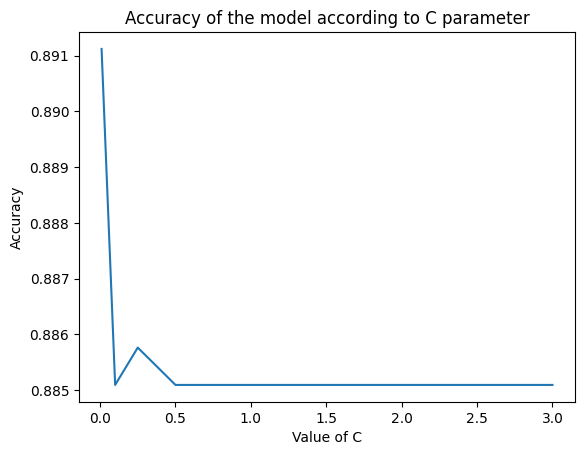

In [ ]:
plt.plot(C, accuracies)
plt.title('Accuracy of the model according to C parameter')
plt.xlabel("Value of C")
plt.ylabel("Accuracy")

### Extracting features on other layer

In [ ]:
layers = [-5,-4,-3,-2,-1]
accuracies=[]
for i in layers:
  accuracies.append(main("15SceneData", layer=i))

Batch : 8 | C : 1 | Layer : -5
Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188


KeyboardInterrupt: ignored

Text(0, 0.5, 'Accuracy')

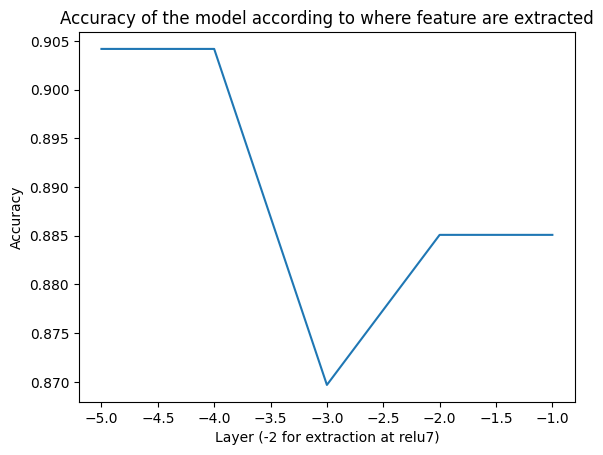

In [ ]:
plt.plot(layers, accuracies)
plt.title('Accuracy of the model according to where feature are extracted')
plt.xlabel("Layer (-2 for extraction at relu7)")
plt.ylabel("Accuracy")